<a href="https://colab.research.google.com/github/JJ-VA/ddpm-tensorflow/blob/main/ddpm-tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduccion a los modelos de difusion

**Autor:** Saul Alvarez Lazaro, Juan Jose Vargas

**Fecha:** 17/07/25

## Introducción

Los modelos generativos han revolucionado el aprendizaje profundo, permitiéndonos crear datos nuevos y realistas. En los últimos años ha surgido una nueva clase de modelos con una potencia y estabilidad impresionantes: los **Modelos de Difusión Probabilística Denoising (DDPMs)**.

La idea central es:
1.  **Proceso Directo:** Se toma una imagen real y se le añade ruido gradualmente hasta que se convierte en ruido puro.
2.  **Proceso Inverso:** Se entrena una red neuronal para revertir este proceso, partiendo de ruido y eliminándolo iterativamente hasta generar una imagen nueva.

Este notebook implementa un DDPM utilizando TensorFlow para generar imágenes de dígitos del dataset MNIST y FashionMNIST.



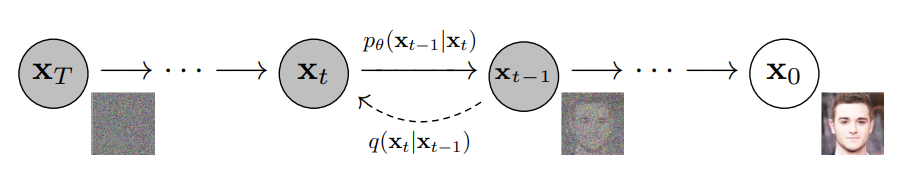

In [ ]:
from IPython.display import Image, display
display(Image(filename="/content/ProcesoInverso.png"))



## Trabajo Relacionado

Este trabajo se basa principalmente en los conceptos presentados en:

* **"Denoising Diffusion Probabilistic Models" (Ho, Jain, and Abbeel, 2020):** El trabajo seminal que popularizó los DDPMs.
* **"U-Net: Convolutional Networks for Biomedical Image Segmentation" (Ronneberger, et al., 2015):** La arquitectura U-Net es la columna vertebral de la mayoría de los modelos de difusión.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 0. CONFIGURACIÓN ---
class Config:
    TIMESTEPS = 150
    IMG_SIZE = 32
    # Se ajusta el BATCH_SIZE para mejor compatibilidad con GPUs de Colab
    BATCH_SIZE = 128
    EPOCHS = 5
    DEVICE = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"

print(f"Usando el dispositivo: {Config.DEVICE}")

# --- 1. DATOS ---
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = tf.image.resize(tf.expand_dims(x_train, -1), [Config.IMG_SIZE, Config.IMG_SIZE])
# Normalizamos los píxeles al rango [-1, 1]
x_train = (tf.cast(x_train, tf.float32) / 255.0 - 0.5) * 2
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(Config.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Forma de los datos de entrenamiento: {x_train.shape}")

Usando el dispositivo: /GPU:0
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Forma de los datos de entrenamiento: (60000, 32, 32, 1)


## Métodos

### Proceso de Difusión Directo (Forward Process)

Este es un proceso fijo que añade ruido a una imagen $x_0$ en $T$ pasos. La propiedad más importante es que podemos muestrear el estado de la imagen $x_t$ en cualquier paso de tiempo $t$ directamente desde la imagen original $x_0$ con la siguiente fórmula:

$$ x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon $$

Donde:
* $x_0$ es la imagen original.
* $\epsilon$ es ruido puro, $\epsilon \sim \mathcal{N}(0, \mathbf{I})$.
* $\bar{\alpha}_t = \prod_{i=1}^{t} (1 - \beta_i)$ es el producto acumulado de los $\alpha_t$.

In [ ]:
# --- 2. DIFUSIÓN DIRECTA ---
betas = tf.linspace(0.0001, 0.02, Config.TIMESTEPS)
alphas = 1.0 - betas
alphas_cumprod = tf.math.cumprod(alphas)

def forward_diffusion(x0, t):
    """Aplica el proceso de difusión directo a un batch de imágenes."""
    noise = tf.random.normal(tf.shape(x0))
    a_t = tf.gather(alphas_cumprod, t)
    # Reajustamos la forma para la multiplicación (broadcasting)
    a_t = tf.reshape(a_t, [-1, 1, 1, 1])
    x_t = tf.sqrt(a_t) * x0 + tf.sqrt(1.0 - a_t) * noise
    return x_t, noise

### Proceso Inverso y Arquitectura del Modelo (U-Net)

El objetivo del proceso inverso es aprender a revertir la difusión. En lugar de predecir la imagen "limpia", es más efectivo entrenar al modelo para que prediga el **ruido** ($\epsilon$) que fue añadido.

* **Entrada:** Una imagen ruidosa $x_t$ y el paso de tiempo $t$.
* **Salida:** La predicción del ruido, $\epsilon_{\theta}(x_t, t)$.
* **Arquitectura:** Usamos una **U-Net**, ideal por sus `skip connections` que preservan los detalles finos de la imagen durante la reconstrucción.

Para que el modelo sepa *cuánto* ruido quitar, le pasamos el `timestep` $t$ codificado como un **embedding posicional sinusoidal**.

In [ ]:
# --- 3. MODELO UNET LIGERO ---
class SinusoidalPosEmb(layers.Layer):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def call(self, time):
        time = tf.cast(time, tf.float32)
        half_dim = self.dim // 2
        emb = tf.math.log(10000.0) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = tf.expand_dims(time, -1) * tf.expand_dims(emb, 0)
        return tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)

class Block(layers.Layer):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_dense = layers.Dense(out_ch)
        self.up = up
        self.conv1 = layers.Conv2D(out_ch, 3, padding='same')
        self.conv2 = layers.Conv2D(out_ch, 3, padding='same')
        self.norm1 = layers.BatchNormalization()
        self.norm2 = layers.BatchNormalization()
        self.activation = tf.nn.relu
        self.transform = (
            layers.Conv2DTranspose(out_ch, 4, strides=2, padding='same') if up else
            layers.Conv2D(out_ch, 4, strides=2, padding='same')
        )

    def call(self, x, t_emb):
        h = self.norm1(self.activation(self.conv1(x)))
        t = self.activation(self.time_dense(t_emb))
        t = tf.reshape(t, [tf.shape(t)[0], 1, 1, tf.shape(t)[-1]])
        h = h + t
        h = self.norm2(self.activation(self.conv2(h)))
        return self.transform(h)

class SimpleUnet(Model):
    def __init__(self):
        super().__init__()
        down_channels = [32, 64, 128]
        up_channels = [128, 64, 32]
        time_emb_dim = 16
        self.time_mlp = tf.keras.Sequential([
            SinusoidalPosEmb(time_emb_dim),
            layers.Dense(time_emb_dim, activation='relu')
        ])
        self.init_conv = layers.Conv2D(down_channels[0], 3, padding='same')
        self.downs = [Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)]
        self.ups = []
        for i in range(len(up_channels)-1):
            # La entrada al bloque de subida tiene el doble de canales por la skip connection
            self.ups.append(Block(up_channels[i]*2, up_channels[i+1], time_emb_dim, up=True))
        self.out_conv = layers.Conv2D(1, 1, padding='same')

    def call(self, x, t):
        t_emb = self.time_mlp(t)
        x = self.init_conv(x)
        residuals = []
        for down in self.downs:
            x = down(x, t_emb)
            residuals.append(x)

        # Invertimos los residuales para usarlos en el camino de subida
        residuals = residuals[::-1]

        for i, up in enumerate(self.ups):
            # El último residual no se concatena, se usa como entrada para el primer bloque 'up'
            if i > 0:
              x = tf.concat([x, residuals[i]], axis=-1)
            x = up(x, t_emb)
        return self.out_conv(x)

### Entrenamiento y Función de Pérdida

El entrenamiento consiste en enseñarle al modelo a predecir el ruido. La función de pérdida es el **Error Cuadrático Medio (MSE)** entre el ruido real $\epsilon$ y el ruido predicho $\epsilon_{\theta}$.

$$ L(\theta) = \mathbb{E}_{t, x_0, \epsilon} \left[ \left\| \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon, t) \right\|^2 \right] $$

In [ ]:
# --- 4. ENTRENAMIENTO ---
model = SimpleUnet()
optimizer = tf.keras.optimizers.Adam(1e-3)
loss_fn = tf.keras.losses.MeanSquaredError()

@tf.function
def train_step(x_batch):
    batch_size = tf.shape(x_batch)[0]
    t = tf.random.uniform([batch_size], minval=0, maxval=Config.TIMESTEPS, dtype=tf.int32)
    with tf.GradientTape() as tape:
        xt, noise = forward_diffusion(x_batch, t)
        pred_noise = model(xt, t)
        loss = loss_fn(noise, pred_noise)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

# Bucle de entrenamiento
with tf.device(Config.DEVICE):
    for epoch in range(Config.EPOCHS):
        print(f"--- Epoch {epoch+1}/{Config.EPOCHS} ---")
        epoch_loss = 0.0
        num_batches = 0
        for batch in tqdm(train_dataset, desc=f"Epoch {epoch+1}"):
            loss = train_step(batch)
            epoch_loss += loss
            num_batches += 1
        avg_loss = epoch_loss / num_batches
        print(f"Loss final de la epoch: {avg_loss.numpy()}")

--- Epoch 1/5 ---


Epoch 1: 100%|██████████| 469/469 [00:35<00:00, 13.13it/s]


Loss final de la epoch: 0.19917114078998566
--- Epoch 2/5 ---


Epoch 2: 100%|██████████| 469/469 [00:19<00:00, 23.76it/s]


Loss final de la epoch: 0.07450710237026215
--- Epoch 3/5 ---


Epoch 3: 100%|██████████| 469/469 [00:20<00:00, 23.16it/s]


Loss final de la epoch: 0.06461937725543976
--- Epoch 4/5 ---


Epoch 4: 100%|██████████| 469/469 [00:20<00:00, 22.83it/s]


Loss final de la epoch: 0.05911175161600113
--- Epoch 5/5 ---


Epoch 5: 100%|██████████| 469/469 [00:20<00:00, 23.13it/s]

Loss final de la epoch: 0.056795209646224976


### Proceso de Muestreo Inverso (Generación)

Una vez entrenado, generamos imágenes partiendo de ruido puro $x_T$. Iteramos hacia atrás de $t=T-1$ hasta $t=0$, usando el modelo para predecir el ruido en cada paso y "limpiar" un poco la imagen con la fórmula:

$$ x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_{\theta}(x_t, t) \right) + \sigma_t z $$

In [ ]:
# --- 5. MUESTREO INVERSO ---
@tf.function
def sample(n_images):
    """Genera imágenes nuevas a partir de ruido."""
    xt = tf.random.normal([n_images, Config.IMG_SIZE, Config.IMG_SIZE, 1])
    for i in reversed(range(Config.TIMESTEPS)):
        t = tf.ones([n_images], dtype=tf.int32) * i
        pred_noise = model(xt, t)

        alpha = tf.gather(alphas, t)
        alpha_cumprod_t = tf.gather(alphas_cumprod, t)
        beta = tf.gather(betas, t)

        alpha = tf.reshape(alpha, [-1, 1, 1, 1])
        beta = tf.reshape(beta, [-1, 1, 1, 1])
        alpha_cumprod_t = tf.reshape(alpha_cumprod_t, [-1, 1, 1, 1])

        xt = (1.0 / tf.sqrt(alpha)) * (
            xt - (beta / tf.sqrt(1.0 - alpha_cumprod_t)) * pred_noise)

        if i > 0:
            xt += tf.sqrt(beta) * tf.random.normal(tf.shape(xt))

    # Des-normalizamos la imagen final de [-1, 1] a [0, 1]
    return tf.clip_by_value((xt + 1) / 2, 0, 1)

Generando imágenes...


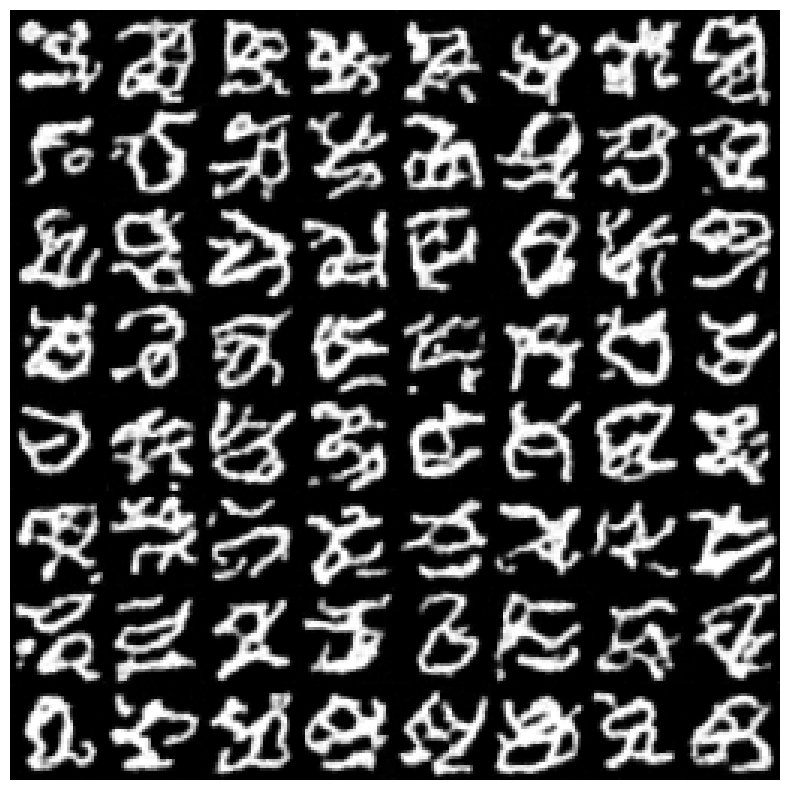

Imágenes generadas y guardadas en 'mnist_generated_tf.png'


In [ ]:
# --- 6. VISUALIZACIÓN ---
print("Generando imágenes...")
with tf.device(Config.DEVICE):
    images = sample(64)

# Convertir a NumPy en la CPU para manipular y mostrar
images_np = images.numpy()

# Reorganizar las imágenes en una cuadrícula de 8x8
images_reshaped = np.reshape(images_np, [8, 8, Config.IMG_SIZE, Config.IMG_SIZE])
images_transposed = np.transpose(images_reshaped, [0, 2, 1, 3])
final_image = np.reshape(images_transposed, [8 * Config.IMG_SIZE, 8 * Config.IMG_SIZE])

plt.figure(figsize=(10, 10))
plt.imshow(final_image, cmap='gray')
plt.axis('off')
plt.savefig("mnist_generated_tf.png")
plt.show()

print("Imágenes generadas y guardadas en 'mnist_generated_tf.png'")

## Conclusiones

* **Aprendizaje Clave:** Descomponer la generación de imágenes en pasos simples de eliminación de ruido es una técnica robusta y efectiva.
* **Destacados del Modelo:**
    * La decisión de **predecir el ruido** simplifica la función de pérdida.
    * La **arquitectura U-Net** con **embeddings de tiempo** es una combinación extremadamente poderosa para esta tarea.
* **Futuras Mejoras:** Se podría usar una U-Net más compleja, entrenar por más tiempo o aplicar el modelo a datasets más complejos como CIFAR-10.